## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [17]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\IPython\core\interactiveshell.py:3699: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [19]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
# --- KHỞI TẠO LLM ---
try:
    # === NÂNG CẤP: Chuyển sang sử dụng API của Google AI Studio (miễn phí) ===
    # Thư viện này sử dụng GOOGLE_API_KEY trực tiếp từ file .env của bạn.
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Pro từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Pro từ Google AI Studio) đã được khởi tạo thành công.


## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [20]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
VECTOR_STORE_PATH = "vector_store/sgk_toan_9"
vector_store = None
if os.path.exists(VECTOR_STORE_PATH):
    try:
        embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
        vector_store = FAISS.load_local(VECTOR_STORE_PATH, embeddings, allow_dangerous_deserialization=True)
        print("✅ Kho tri thức RAG đã được tải thành công.")
    except Exception as e:
        print(f"❌ LỖI khi tải kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy kho tri thức tại '{VECTOR_STORE_PATH}'.")

c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Kho tri thức RAG đã được tải thành công.


In [21]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE MỞ RỘNG (v7.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === NÂNG CẤP V7.0: ĐỊNH NGHĨA STATE VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV4(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    
    # === NÂNG CẤP #1: LƯU TRỮ LĨNH VỰC CHUYÊN MÔN ===
    domain: Optional[str]
    
    # === NÂNG CẤP #3: LƯU TRỮ HỒ SƠ HỌC SINH ===
    student_persona: Optional[Dict[str, Any]]
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    
    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    final_lesson_plan: Optional[str]
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

print("✅ 'TeacherStateV4' (v7.0 - Mở rộng) đã được định nghĩa.")

✅ 'TeacherStateV4' (v7.0 - Mở rộng) đã được định nghĩa.


In [22]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV4) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [23]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH, PERSONA & CÁC CẤU TRÚC DỮ LIỆU (v7.5)
# ==============================================================================
import json
from langchain_core.pydantic_v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- HÀM TIỆN ÍCH & PERSONA ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def update_agent_outputs(state: "TeacherStateV4", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# --- PYDANTIC MODELS V7.5 ---
class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập. Ví dụ: 'Khám phá Vòng tròn Bí ẩn'")
    description: str = Field(description="Mô tả chi tiết các bước. Ví dụ: 'Giáo viên chiếu hình ảnh một tam giác có đường tròn ngoại tiếp. Yêu cầu các đội thảo luận 2 câu hỏi...'")
    duration_minutes: int = Field(description="Thời gian ước tính (bằng SỐ PHÚT).")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm'")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở cụ thể. Ví dụ: ['Câu hỏi 1: Vòng tròn này có đặc điểm gì so với các đỉnh?', 'Câu hỏi 2: Làm thế nào để xác định tâm của nó?']")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá. Ví dụ: 'Thử thách cuối bài'")
    question: str = Field(description="Nội dung câu hỏi hoặc đề bài toán cụ thể.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận'")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    duration_minutes: int = Field(description="Thời gian ước tính (bằng SỐ PHÚT).")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập. BẮT BUỘC là: 'nhanh', 'trung bình', 'chậm'.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia. BẮT BUỘC là: 'chủ động', 'thụ động', 'hỗn hợp'.")
    special_notes: str = Field(description="Ghi chú đặc biệt về lớp học.")

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")

class Domain(BaseModel):
    domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu (ví dụ: 'Toán học', 'Văn học', 'Vật lý', 'Lịch sử').")

class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]

class BlueprintStage(BaseModel):
    stage_name: str = Field(description="Tên của giai đoạn, ví dụ: 'Giai đoạn 1: Khơi gợi'")
    stage_objective: str = Field(description="Mô tả mục tiêu nhận thức và cảm xúc của giai đoạn này.")
    stage_direction: str = Field(description="Định hướng chung về hoạt động sẽ diễn ra trong giai đoạn này.")

class PedagogicalBlueprint(BaseModel):
    blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic đã được định nghĩa.


In [24]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (v7.5)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

async def student_persona_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Student Persona Adapter` (v7.5) đang phân tích đặc điểm lớp học...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ DUY NHẤT:** Chỉ tập trung vào việc phân tích các cụm từ mô tả đặc điểm của lớp học trong yêu cầu dưới đây. Bỏ qua tất cả các thông tin khác.
    **YÊU CẦU NGƯỜI DÙNG:** "{state['original_request']}"
    
    **CÁC ĐẶC ĐIỂM CẦN TRÍCH XUẤT:**
    1.  `learning_pace`: Tốc độ học (nhanh, trung bình, hay chậm?).
    2.  `engagement_style`: Phong cách tương tác (chủ động hay thụ động?).
    3.  `special_notes`: Tóm tắt các đặc điểm đó thành một ghi chú ngắn.

    Nếu không có thông tin, hãy giả định là 'trung bình' và 'hỗn hợp'.
    **CHỈ TRẢ VỀ JSON THEO SCHEMA `StudentPersona`.**
    """
    structured_llm = llm.with_structured_output(StudentPersona, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học đã được phân tích")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Student Persona Adapter: {e}. Sử dụng hồ sơ mặc định.")
        return {"student_persona": {"learning_pace": "trung bình", "engagement_style": "hỗn hợp", "special_notes": "Không có ghi chú đặc biệt."}}

print("✅ Các agent phân tích yêu cầu ban đầu đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu đã sẵn sàng.


In [25]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v7.5) đang thiết kế kịch bản buổi học...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [26]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v7.5) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    summary_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Dựa vào các đoạn văn bản sau, tóm tắt các kiến thức cốt lõi nhất về chủ đề \"{state.get('analyzed_objective', {}).get('topic', '')}\".\n**QUY TẮC:** Tóm tắt phải cô đọng, mạch lạc, tập trung vào định nghĩa và định lý chính.\n**CÁC ĐOẠN VĂN BẢN:**\n{best_snippets_text}"
    summary = "Chưa có tóm tắt."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [27]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC VÀ CÁC AGENT CHUYÊN MÔN (v7.5)
# ==============================================================================
async def plan_delegator_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v7.5) đang triển khai Bản thiết kế...")
    critic_feedback_prompt = f"**PHẢN HỒI TỪ LẦN TRƯỚC (CẦN SỬA):** \"{state.get('reflection_notes', '')}\"."
    blueprint = state.get('pedagogical_blueprint', ["Giai đoạn mặc định: Soạn giáo án"])
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một người quản lý dự án giáo dục hiệu quả.
    **NHIỆM VỤ:** Triển khai **Bản thiết kế Sư phạm** dưới đây thành một danh sách các **HOẠT ĐỘNG DÀNH CHO HỌC SINH**.
    
    **BẢN THIẾT KẾ SƯ PHẠM (KỊCH BẢN BUỔI HỌC):**
    {json.dumps(blueprint, ensure_ascii=False, indent=2)}
    
    **QUY TẮC TUYỆT ĐỐI:**
    1.  **TẬP TRUNG VÀO HỌC SINH:** Mỗi task phải là một hoạt động mà **HỌC SINH** sẽ làm. Ví dụ: "Học sinh thảo luận nhóm về...", "Học sinh giải bài tập...".
    2.  **KHÔNG TẠO TASK CHO GIÁO VIÊN:** Tuyệt đối **KHÔNG** được tạo ra các nhiệm vụ chung chung cho giáo viên như "Soạn giáo án" hay "Chuẩn bị bài".
    3.  **Bám sát Bản thiết kế:** Mỗi giai đoạn trong blueprint phải được chuyển thành ít nhất một task cụ thể.
    4.  **Phân bổ Thời gian:** Chia tổng thời lượng {state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)} phút một cách hợp lý cho các task.
    
    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về JSON tuân thủ schema `TaskListWithDuration`.
    ```json
    {schema_json_of(TaskListWithDuration, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chi tiết")
        new_agent_outputs = {"resources": state.get("agent_outputs", {}).get("resources", [])}
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    except Exception as e:
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        return {"task_list": [{"task_id": 0, "task_name": "Hoạt động luyện tập", "task_description": "Học sinh thực hành bài tập về đường tròn ngoại tiếp.", "estimated_duration": 45, "status": "pending"}], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}

async def specialist_agent_logic(state: "TeacherStateV4", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v7.5) đang tạo nội dung chi tiết...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}, "validation_feedback": None}

    feedback_prompt = f"**PHẢN HỒI TỪ LẦN TRƯỚC (CẦN SỬA):** \"{state.get('validation_feedback', '')}\"." if state.get('validation_feedback') else ""

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **BẠN CHỈ LÀ MỘT NGƯỜI THỰC THI NHIỆM VỤ NHỎ.**
    Nhiệm vụ của bạn **KHÔNG PHẢI** là soạn toàn bộ giáo án.
    Nhiệm vụ của bạn là tạo ra **MỘT HOẠT ĐỘNG DUY NHẤT** dựa trên mô tả dưới đây.

    **BỐI CẢNH BÀI HỌC:**
    - **Chủ đề chính:** {state.get('analyzed_objective', {}).get('topic', '')}
    
    **MÔ TẢ NHIỆM VỤ CẦN THỰC THI:**
    - **Tên nhiệm vụ:** "{task_to_run.get('task_name', '')}"
    - **Mô tả chi tiết:** "{task_to_run.get('task_description', '')}"
    
    {feedback_prompt}
    
    **QUY TẮC TUYỆT ĐỐI:**
    1.  **TẠO NỘI DUNG CỤ THỂ:** Đưa ra câu hỏi, đề bài toán cụ thể.
    2.  **TUÂN THỦ SCHEMA:** Chỉ trả về một đối tượng JSON duy nhất theo đúng cấu trúc dưới đây.
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        content_dict['duration_minutes'] = task_to_run.get('estimated_duration', 10)
        print_result(content_dict, f"Nội dung do {agent_type} tạo ra")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}. Trả về nội dung mặc định.")
        return {"current_content_to_validate": {"error": str(e)}, "validation_feedback": None}

async def theory_synthesizer_agent(state: "TeacherStateV4"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV4"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV4"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("✅ Các agent giao việc và chuyên môn đã sẵn sàng.")

✅ Các agent giao việc và chuyên môn đã sẵn sàng.


In [28]:
# ==============================================================================
# CELL 3.6: AGENT PHẢN BIỆN VÀ TỔNG HỢP CUỐI CÙNG (v7.5)
# ==============================================================================
async def content_validator_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step(f"`Agent: Contextual Critic` (v7.5) đang phản biện nội dung...")
    content = state.get('current_content_to_validate')
    if not content or content.get("error"):
        print_warning("Bỏ qua phản biện do lỗi ở bước tạo nội dung.")
        return {"validation_feedback": "Lỗi tạo nội dung, không thể phản biện.", "current_content_to_validate": content}
    
    prompt = f"""BẠN LÀ MỘT GIÁO VIÊN LỚP {state.get('analyzed_objective', {}).get('grade_level', '9')} CỰC KỲ KINH NGHIỆM VÀ CẨN THẬN, VỚI CHUYÊN MÔN SÂU VỀ **{state.get('domain', 'Toán học')}**.
    **BỐI CẢNH:** Buổi học hôm nay có chủ đề chính là **"{state.get('analyzed_objective', {}).get('topic', '')}"**.
    **NHIỆM VỤ:** Hãy xem xét nội dung được tạo ra cho một hoạt động trong giáo án.
    **NỘI DUNG CẦN XEM XÉT:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```
    **TIÊU CHÍ PHẢN BIỆN (THEO THỨ TỰ ƯU TIÊN):**
    1.  **Tính liên quan:** Nội dung này có liên quan trực tiếp đến chủ đề chính của bài học không?
    2.  **Tính chính xác chuyên môn:** Nội dung có sai sót nào về kiến thức, công thức, logic không?
    3.  **Tính phù hợp lứa tuổi:** Nội dung có quá khó hoặc quá dễ so với học sinh không?
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với 2 key `is_valid` (boolean) và `feedback` (string).
    """
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        if not result.is_valid:
            print_warning(f"PHẢN BIỆN: {result.feedback}")
            return {"validation_feedback": result.feedback, "current_content_to_validate": content}
        else:
            print_step("✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!")
            return {"validation_feedback": None, "current_content_to_validate": content}
    except Exception as e:
        print_warning(f"Lỗi tại Content Validator: {e}. Mặc định cho qua.")
        return {"validation_feedback": None, "current_content_to_validate": content}

async def plan_compiler_and_critic_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Plan Compiler & Critic` (v7.5) đang tổng hợp và đánh giá...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)
    is_duration_valid = (allowed_duration * 0.85) <= total_duration <= (allowed_duration + 10)

    if not all_content_items or len(all_content_items) < 3 or not is_duration_valid:
        reflection = f"Kế hoạch thất bại. Tổng thời gian thực tế ({total_duration} phút) nằm ngoài khoảng cho phép (yêu cầu khoảng {allowed_duration * 0.85:.0f} - {allowed_duration + 10} phút). Hoặc số lượng hoạt động ({len(all_content_items)}) quá ít. Hãy lập kế hoạch lại."
        print_warning(f"CRITIC: {reflection}")
        return {"reflection_notes": reflection, "final_lesson_plan": None, "agent_outputs": {"resources": outputs.get("resources", [])}}

    print_step("CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án chi tiết...")
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))
    content_md_parts = []
    
    for i, content in enumerate(all_content_sorted):
        title = f"### Hoạt động {i+1}: {content.get('activity_name', 'N/A')} ({content.get('duration_minutes', 0)} phút)"
        if 'question' in content:
            details = (f"*   **Loại hình:** {content.get('question_type', 'Đánh giá')}\n"
                       f"*   **Đề bài:**\n{content.get('question', 'N/A')}\n\n"
                       f"*   **Đáp án:** {content.get('answer', 'N/A')}\n"
                       f"*   **Hướng dẫn giải chi tiết:**\n{format_solution_guide(content.get('solution_guide'))}\n")
        else:
            details = (f"*   **Loại hình:** {content.get('activity_type', 'N/A')}\n"
                       f"*   **Mô tả/Nhiệm vụ:**\n{content.get('description', 'N/A')}\n\n"
                       f"*   **Gợi ý đáp án/Hướng dẫn giải:**\n{format_solution_guide(content.get('solution_guide'))}\n")
        content_md_parts.append(f"{title}\n\n{details}")
    
    content_md = "\n---\n\n".join(content_md_parts)
    final_plan_str = f"""# GIÁO ÁN BÀI DẠY: {objective.get('topic', 'N/A')}
---
## I. THÔNG TIN CHUNG
- **Môn học:** {state.get('domain', 'N/A')}
- **Lớp:** {objective.get('grade_level', 'N/A')}
- **Thời lượng dự kiến:** {total_duration} phút / {allowed_duration} phút
- **Phương pháp sư phạm chủ đạo:** {state.get('pedagogy_strategy', {}).get('name', 'Chưa xác định')}
- **Đặc điểm lớp học:** {state.get('student_persona', {}).get('special_notes', 'Tiêu chuẩn')}
---
## II. MỤC TIÊU BÀI HỌC
- Học sinh có thể **{objective.get('action_verb', 'vận dụng')}** kiến thức về {objective.get('topic', 'N/A')} để giải quyết các bài toán liên quan.
- Rèn luyện kỹ năng tư duy logic, mô hình hóa toán học và giải quyết vấn đề.
---
## III. CHUẨN BỊ
- **Giáo viên:** Bảng phụ, phấn màu, phiếu học tập (nếu có).
- **Học sinh:** Sách giáo khoa, vở ghi, dụng cụ học tập.
- **Nguồn tài liệu tham khảo:** {state.get('agent_outputs', {}).get('resources', [{}])[0].get('source', 'N/A')}
---
## IV. TIẾN TRÌNH BÀI DẠY
{content_md}
---
## V. TÓM TẮT KIẾN THỨC CỐT LÕI
{state.get('agent_outputs', {}).get('resources', [{}])[0].get('summary', 'Chưa có tóm tắt.')}
"""
    return {"final_lesson_plan": final_plan_str, "reflection_notes": None}

print("✅ Agent phản biện và tổng hợp cuối cùng đã sẵn sàng.")

✅ Agent phản biện và tổng hợp cuối cùng đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [29]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH VÀ ĐIỀU PHỐI CỦA GRAPH (v7.1)
# ==============================================================================
from typing import Literal, Dict, Any

def mark_task_complete(state: "TeacherStateV4") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler & Critic.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Task Dispatcher` (v7.1) Bắt đầu...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run:
        print_warning("Dispatcher không tìm thấy task, sẽ bỏ qua bước này.")
        return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent sau: 'activity_designer', 'theory_synthesizer', 'assessment_creator'.\n\n**QUY TẮC PHÂN LOẠI:**\n- Giảng giải, giới thiệu, ôn tập, tổng kết -> 'theory_synthesizer'.\n- Luyện tập, thực hành, thảo luận, làm việc nhóm -> 'activity_designer'.\n- Kiểm tra, đánh giá, bài toán khó, vận dụng cao -> 'assessment_creator'.\n\n**NHIỆM VỤ CẦN PHÂN LOẠI:** \"{task_description}\"\n\n**YÊU CẦU JSON:** Trả về JSON với key duy nhất là `agent_category`."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception as e:
        print_warning(f"Lỗi tại Dispatcher: {e}. Giao nhiệm vụ cho 'activity_designer'.")
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    
    content['task_id'] = state['current_task_id']
    
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    return updated_outputs

print("✅ Các node tiện ích và điều phối của graph đã sẵn sàng.")

✅ Các node tiện ích và điều phối của graph đã sẵn sàng.


In [30]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN
# ==============================================================================
def route_after_validation(state: "TeacherStateV4") -> Literal["commit", "retry"]:
    if state.get("validation_feedback") is None:
        print_step("ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.")
        return "commit"
    else:
        print_step("ROUTER (Validation): Nội dung bị từ chối. Quay lại để thử lại.")
        return "retry"

def route_after_router(state: "TeacherStateV4") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: return "compile_and_critique"
    else: return "continue_executing"

def route_after_compilation(state: "TeacherStateV4") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng đã được định nghĩa.")

✅ Các hàm logic điều hướng đã được định nghĩa.


In [31]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (v7.1)
# ==============================================================================
workflow = StateGraph(TeacherStateV4)

# Thêm các node vào graph
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("student_persona_adapter", student_persona_agent)
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)
workflow.add_node("plan_compiler_and_critic", plan_compiler_and_critic_agent)

# Thiết lập các kết nối (edges)
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "student_persona_adapter")
workflow.add_edge("student_persona_adapter", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")

# Các kết nối có điều kiện
workflow.add_conditional_edges("task_router", route_after_router, {"continue_executing": "task_dispatcher", "compile_and_critique": "plan_compiler_and_critic"})
workflow.add_conditional_edges("task_dispatcher", lambda state: state["next_agent"], {"activity_designer": "activity_designer", "assessment_creator": "assessment_creator", "theory_synthesizer": "theory_synthesizer"})
workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")
workflow.add_conditional_edges("content_validator", route_after_validation, {"commit": "commit_validated_content", "retry": "task_dispatcher"})
workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "task_router")
workflow.add_conditional_edges("plan_compiler_and_critic", route_after_compilation, {"replan": "plan_delegator", "finish": END})

# Biên dịch graph
app = workflow.compile()
print("✅ Graph 7.1 (The Architect) đã được biên dịch thành công.")

✅ Graph 7.1 (The Architect) đã được biên dịch thành công.


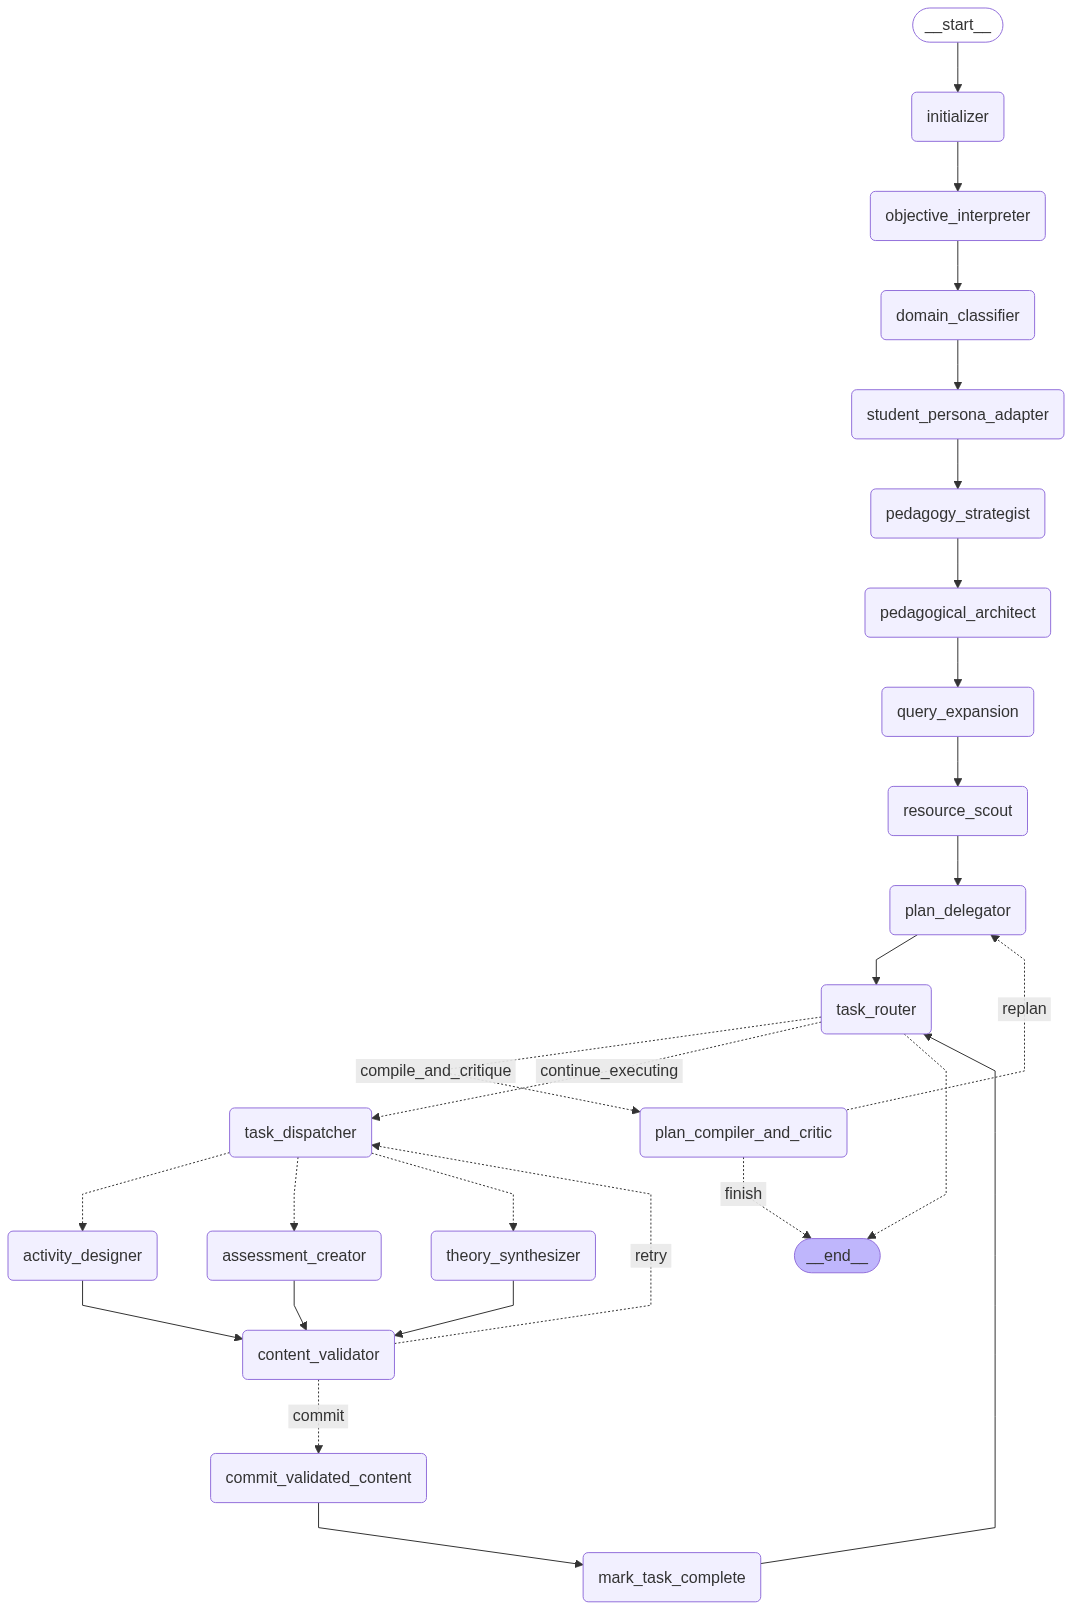

In [32]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [33]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo. Vui lòng chạy lại Cell 1.3.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải. Vui lòng chạy lại Cell 1.4.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch. Vui lòng chạy lại Cell 4.3.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_state_result = None
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                final_state_result = node_output

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH V7.1.[/bold magenta]")
        
        if final_state_result and final_state_result.get("final_lesson_plan"):
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v7.1)[/bold green]")
            console.print(Markdown(final_state_result["final_lesson_plan"]))
        else:
            print_warning("Không tạo được giáo án cuối cùng. Có thể Critic đã yêu cầu làm lại nhưng hết giới hạn đệ quy.")
            print("\nTrạng thái cuối cùng để gỡ lỗi:")
            pprint(final_state_result)
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` đã sẵn sàng để sử dụng.


In [34]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 2,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': 'Lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Student Persona Adapter` (v7.5) đang phân tích đặc điểm lớp học...

✔️ Hồ sơ lớp học đã được phân tích:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'chủ động',
│   'special_notes': 'Lớp học yếu, học sinh dễ mất tập trung, cần nhiều hoạt động tương tác.'
}

------- Hoàn thành bước: student_persona_adapter -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác (Cooperative Learning)',
│   'rationale': 'Phương pháp này đặc biệt phù hợp với lớp học yếu, học sinh dễ mất tập trung và có tốc độ học chậm vì nó khuyến khích sự tương tác liên tục giữa các học sinh, tạo cơ hội cho các em hỗ trợ lẫn nhau. Các hoạt động nhóm giúp duy trì sự chú ý, phát huy tính chủ động và biến quá trình học tập thành trải nghiệm thú vị, giảm bớt áp lực cá nhân. Điều này rất quan trọng để giúp học sinh nắm vững kiến thức cơ bản về đường tròn ngoại tiếp và nội tiếp.',
│   'key_actions': [
│   │   'Chia nhóm học sinh và giao nhiệm vụ cụ thể liên quan đến các khía cạnh của đường tròn ngoại tiếp và nội tiếp (ví dụ: nhóm 1 tìm hiểu định nghĩa và tính chất đường tròn ngoại tiếp, nhóm 2 tìm hiểu định nghĩa và tính chất đường tròn nội tiếp, nhóm 3 thực hành vẽ).',
│   │   'Học sinh làm việc nhóm để khám phá, thảo luận, vẽ hình và hoàn thành phiếu bài tập/nhiệm vụ được giao.',
│   │   'Giáo viên quan sát, hỗ trợ, gợi mở và giải đáp thắc mắc cho từng nhóm.',
│   │   'Đại diện các nhóm trình bày kết quả làm việc của nhóm mình trước lớp.',
│   │   'Giáo viên tổng kết, chuẩn hóa kiến thức, hệ thống hóa các khái niệm và tính chất quan trọng.',
│   │   'Tổ chức hoạt động luyện tập ngắn để củng cố kiến thức vừa học.'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v7.5) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   'Giai đoạn 1: Khơi gợi & Kết nối: Giáo viên sử dụng một câu hỏi gợi mở hoặc hình ảnh trực quan để thu hút sự chú ý, khuyến khích học sinh chia sẻ những gì đã biết về đường tròn và tam giác, từ đó dẫn dắt vào bài mới.',
│   'Giai đoạn 2: Khám phá & Hình thành kiến thức: Chia lớp thành các nhóm nhỏ. Mỗi nhóm được giao một nhiệm vụ cụ thể (ví dụ: tìm hiểu đường tròn ngoại tiếp, đường tròn nội tiếp, hoặc thực hành vẽ). Học sinh làm việc nhóm, thảo luận, ghi chép và chuẩn bị trình bày. Giáo viên quan sát, hỗ trợ và gợi mở khi cần.',
│   'Giai đoạn 3: Trình bày & Chuẩn hóa: Đại diện các nhóm lần lượt trình bày kết quả làm việc của nhóm mình. Các nhóm khác lắng nghe, đặt câu hỏi và bổ sung. Giáo viên tổng kết, làm rõ các khái niệm, tính chất, và cách vẽ đường tròn ngoại tiếp/nội tiếp, ghi bảng những nội dung cốt lõi.',
│   'Giai đoạn 4: Luyện tập & Vận dụng: Giáo viên cung cấp các bài tập ngắn, đa dạng (ví dụ: nhận dạng, điền khuyết, vẽ hình đơn giản) để học sinh thực hành cá nhân hoặc theo cặp. Giáo viên đi vòng quanh lớp hỗ trợ, kiểm tra và chữa bài nhanh.',
│   'Giai đoạn 5: Tổng kết & Mở rộng: Giáo viên cùng học sinh tóm tắt các điểm chính của bài học. Giải đáp các câu hỏi còn lại. Giao bài tập về nhà và gợi ý các tài liệu tham khảo để học sinh tự học thêm.'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'đường tròn ngoại tiếp và nội tiếp',
│   'công thức đường tròn ngoại tiếp tam giác',
│   'công thức đường tròn nội tiếp tam giác',
│   'tính bán kính đường tròn ngoại tiếp',
│   'tính bán kính đường tròn nội tiếp',
│   'bài tập đường tròn ngoại tiếp nội tiếp lớp 9',
│   'chuyên đề đường tròn ngoại tiếp và nội tiếp',
│   'lý thuyết đường tròn ngoại tiếp tam giác',
│   'lý thuyết đường tròn nội tiếp tam giác',
│   'tâm đường tròn ngoại tiếp là gì',
│   'tâm đường tròn nội tiếp là gì',
│   'ứng dụng đường tròn ngoại tiếp nội tiếp',
│   'phương pháp giải bài tập đường tròn ngoại tiếp',
│   'phương pháp giải bài tập đường tròn nội tiếp',
│   'quan hệ giữa đường tròn ngoại tiếp và nội tiếp',
│   'đường tròn ngoại tiếp tam giác vuông',
│   'đường tròn nội tiếp tam giác đều',
│   'đường tròn ngoại tiếp tứ giác',
│   'bài tập nâng cao đường tròn ngoại tiếp nội tiếp',
│   'sách giáo khoa đường tròn ngoại tiếp nội tiếp'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v7.5) đang tìm kiếm và sàng lọc...

> Tìm thấy 100 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào các em học sinh thân mến!\n\nHôm nay, thầy/cô sẽ cùng các em tổng hợp lại những kiến thức cốt lõi về hai loại đường tròn rất quan trọng trong hình học: **Đường tròn ngoại tiếp** và **Đường tròn nội tiếp**, dựa trên các bài tập và khái niệm chúng ta đã tìm hiểu.\n\n---\n\n### **1. Đường tròn ngoại tiếp**\n\n*   **Định nghĩa:** Đường tròn ngoại tiếp một đa giác là đường tròn đi qua tất cả các đỉnh của đa giác đó. (Ví dụ: Đường tròn đi qua ba đỉnh A, B, C của tam giác – Bài 5.21, 5.2; hoặc đi qua bốn đỉnh A, B, C, D của hình vuông – Bài 5.4).\n\n*   **Sự tồn tại và Tâm:**\n    *   **Đối với tam giác:** Mọi tam giác đều có một đường tròn ngoại tiếp.\n        *   Tâm của đường tròn ngoại tiếp tam giác vuông là trung điểm của cạnh huyền. (Bài 5.2)\n    *   **Đối với hình vuông:** Có một đường tròn đi qua bốn đỉnh của hình vuông.\n        *   Tâm của đường tròn ngoại tiếp hình vuông là giao điểm của hai đường chéo. (Bài 5.4)\n\n*   **Bán kính:** Bán kính của đường tròn ngoại tiếp có thể được tính toán dựa trên kích thước của đa giác. (Bài 5.2, 5.4)\n\n---\n\n### **2. Đường tròn nội tiếp**\n\n*   **Định nghĩa:** Đường tròn nội tiếp một đa giác là đường tròn tiếp xúc với tất cả các cạnh của đa giác đó. (Khái niệm này được suy ra từ việc "tiếp xúc với cả hai cạnh của góc" – Thử thách nhỏ, Bài 5.22, và các tính chất của tiếp tuyến – Bài 5.23).\n\n*   **Sự tồn tại và Tâm:**\n    *   **Đối với một góc:** Có thể vẽ được đường tròn tiếp xúc với cả hai cạnh của góc đó.\n    *   Tâm của đường tròn tiếp xúc với hai cạnh của một góc nằm trên đường phân giác của góc đó. (Bài 5.22)\n\n*   **Tính chất của tiếp tuyến (liên quan đến đường tròn nội tiếp):**\n    *   Nếu từ một điểm bên ngoài đường tròn, ta kẻ hai tiếp tuyến đến đường tròn đó, thì hai tiếp tuyến này có độ dài bằng nhau. (Ví dụ: SA = SB trong Bài 5.23).\n    *   Chu vi của tam giác tạo bởi hai tiếp tuyến cắt nhau và một tiếp tuyến bất kỳ khác của đường tròn sẽ bằng tổng độ dài của hai tiếp tuyến ban đầu. (Ví dụ: Chu vi tam giác SEF = SA + SB trong Bài 5.23a).\n\n---\n\nHy vọng phần tóm tắt này sẽ giúp các em nắm vững kiến thức cốt lõi về đường tròn ngoại tiếp và đường tròn nội tiếp. Nếu có bất kỳ thắc mắc nào, đừng ngần ngại hỏi thầy/cô nhé!'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v7.5) đang triển khai Bản thiết kế...

✔️ Đã tạo 4 nhiệm vụ chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Học sinh khởi động và ôn tập kiến thức cũ',
│   │   'task_description': 'Học sinh tham gia các hoạt động khởi động như trò chơi nhỏ, câu hỏi nhanh hoặc thảo luận ngắn để kích hoạt tư duy và ôn lại kiến thức nền tảng liên quan đến bài học mới.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Học sinh tiếp thu kiến thức mới',
│   │   'task_description': 'Học sinh tập trung lắng nghe giáo viên trình bày các khái niệm, lý thuyết hoặc nội dung mới của bài học. Học sinh chủ động ghi chép, đặt câu hỏi để làm rõ những điểm chưa hiểu và tương tác với giáo viên khi cần thiết.',
│   │   'estimated_duration': 35,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Học sinh thực hành và vận dụng kiến thức',
│   │   'task_description': 'Học sinh làm việc theo nhóm hoặc cá nhân để giải quyết các bài tập thực hành, phân tích tình huống, hoặc thực hiện các hoạt động ứng dụng kiến thức vừa học. Học sinh thảo luận, hợp tác và trình bày kết quả của mình.',
│   │   'estimated_duration': 35,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Học sinh củng cố và tổng kết bài học',
│   │   'task_description': 'Học sinh cùng giáo viên tổng kết lại các nội dung chính, các khái niệm quan trọng của buổi học. Học sinh có thể đặt câu hỏi cuối buổi và ghi chú các điểm cần ghi nhớ hoặc chuẩn bị cho buổi học tiếp theo.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Học sinh khởi động và ôn tập kiến thức cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v7.5) đang tạo nội dung chi tiết...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động: Ôn tập Kiến thức Đường tròn',
│   'description': "Giáo viên tổ chức trò chơi 'Ai nhanh hơn?' hoặc 'Đố vui toán học' với các câu hỏi trắc nghiệm nhanh hoặc điền vào chỗ trống về kiến thức cơ bản của đường tròn đã học ở các lớp dưới. Các câu hỏi tập trung vào định nghĩa đường tròn, các yếu tố của đường tròn (tâm, bán kính, đường kính, dây cung, cung, tiếp tuyến), và vị trí tương đối của đường thẳng với đường tròn. Ví dụ: 'Tập hợp các điểm cách đều một điểm cố định cho trước là gì?', 'Đoạn thẳng nối hai điểm bất kỳ trên đường tròn được gọi là gì?', 'Đường thẳng chỉ có một điểm chung với đường tròn được gọi là gì?', 'Tính chất của tiếp tuyến với bán kính tại tiếp điểm là gì?'.",
│   'duration_minutes': 10,
│   'activity_type': 'Câu hỏi nhanh',
│   'solution_guide': [
│   │   'Đường tròn',
│   │   'Dây cung',
│   │   'Tiếp tuyến',
│   │   'Vuông góc'
│   ]
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v7.5) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Học sinh tiếp thu kiến thức mới' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v7.5) đang tạo nội dung chi tiết...

✔️ Nội dung do Theory Synthesizer tạo ra:

{
│   'activity_name': 'Thuyết trình và tiếp thu kiến thức mới: Đường tròn ngoại tiếp và nội tiếp',
│   'description': 'Giáo viên sử dụng bảng, máy chiếu hoặc các công cụ trực quan để trình bày chi tiết các khái niệm: Đường tròn ngoại tiếp tam giác (định nghĩa, tính chất, cách xác định tâm là giao điểm ba đường trung trực, bán kính) và Đường tròn nội tiếp tam giác (định nghĩa, tính chất, cách xác định tâm là giao điểm ba đường phân giác, bán kính). Giáo viên đưa ra các ví dụ minh họa cụ thể cho từng loại đường tròn trên các dạng tam giác khác nhau (vuông, cân, đều). Học sinh tập trung lắng nghe, ghi chép các định nghĩa, công thức và tính chất quan trọng. Học sinh được khuyến khích đặt câu hỏi ngay lập tức nếu có bất kỳ điểm nào chưa hiểu rõ hoặc muốn làm sâu sắc thêm kiến thức.',
│   'duration_minutes': 35,
│   'activity_type': 'Giảng bài và tiếp thu kiến thức',
│   'solution_guide': [
│   │   'Giáo viên cần nhấn mạnh sự khác biệt cơ bản giữa tâm đường tròn ngoại tiếp và tâm đường tròn nội tiếp.',
│   │   "Câu hỏi gợi mở: 'Tâm đường tròn ngoại tiếp của tam giác vuông nằm ở vị trí đặc biệt nào?'",
│   │   "Câu hỏi gợi mở: 'Làm thế nào để xác định tâm đường tròn nội tiếp của một tam giác bất kỳ?'",
│   │   'Giáo viên có thể yêu cầu học sinh nhắc lại định nghĩa hoặc tính chất sau khi trình bày xong mỗi phần.'
│   ]
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v7.5) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Học sinh thực hành và vận dụng kiến thức' (ID: 2)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v7.5) đang tạo nội dung chi tiết...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Thực hành và Vận dụng: Đường tròn Ngoại tiếp và Nội tiếp',
│   'description': 'Giáo viên chia lớp thành các nhóm nhỏ (hoặc cá nhân). Mỗi nhóm/cá nhân nhận một phiếu bài tập gồm các bài toán thực hành và tình huống ứng dụng về đường tròn ngoại tiếp và nội tiếp. Học sinh thảo luận, hợp tác giải quyết và chuẩn bị trình bày kết quả.\n\nBài tập:\n1. Cho tam giác ABC có các cạnh AB=6cm, BC=8cm, CA=10cm.\n   a) Chứng minh tam giác ABC là tam giác vuông.\n   b) Tính bán kính đường tròn ngoại tiếp tam giác ABC.\n   c) Tính bán kính đường tròn nội tiếp tam giác ABC.\n2. Một mảnh đất hình tam giác có ba đỉnh A, B, C. Người ta muốn đặt một trạm phát sóng sao cho nó cách đều ba đỉnh của mảnh đất. Hỏi vị trí đặt trạm phát sóng đó là điểm nào? Giải thích.',
│   'duration_minutes': 35,
│   'activity_type': 'Giải bài tập nhóm',
│   'solution_guide': [
│   │   'Gợi ý Bài 1a: Sử dụng định lý Pytago đảo.',
│   │   'Gợi ý Bài 1b: Tâm đường tròn ngoại tiếp tam giác vuông là trung điểm cạnh huyền, bán kính bằng một nửa cạnh huyền.',
│   │   'Gợi ý Bài 1c: Sử dụng công thức diện tích tam giác S = pr (với p là nửa chu vi, r là bán kính đường tròn nội tiếp) hoặc công thức r = (a+b-c)/2 cho tam giác vuông.',
│   │   'Gợi ý Bài 2: Vị trí cách đều ba đỉnh của tam giác chính là tâm đường tròn ngoại tiếp tam giác đó.'
│   ]
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v7.5) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Học sinh củng cố và tổng kết bài học' (ID: 3)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v7.5) đang tạo nội dung chi tiết...

✔️ Nội dung do Theory Synthesizer tạo ra:

{
│   'activity_name': 'Tổng kết và Củng cố Kiến thức',
│   'description': 'Giáo viên dẫn dắt học sinh tổng kết lại các nội dung chính của buổi học về đường tròn ngoại tiếp và đường tròn nội tiếp. Học sinh được yêu cầu nhắc lại các khái niệm cơ bản (định nghĩa, tâm, bán kính) và các tính chất quan trọng của từng loại đường tròn. Giáo viên đặt câu hỏi gợi mở để học sinh hệ thống hóa kiến thức. Cuối buổi, học sinh có thể đặt câu hỏi về những nội dung còn thắc mắc. Giáo viên sẽ chốt lại các điểm cần ghi nhớ và dặn dò học sinh chuẩn bị cho bài học tiếp theo.',
│   'duration_minutes': 10,
│   'activity_type': 'Tổng kết bài học',
│   'solution_guide': [
│   │   'Đường tròn ngoại tiếp tam giác là gì? Tâm và bán kính của nó được xác định như thế nào?',
│   │   'Đường tròn nội tiếp tam giác là gì? Tâm và bán kính của nó được xác định như thế nào?',
│   │   'Nêu mối liên hệ giữa tâm đường tròn ngoại tiếp/nội tiếp với các đường đặc biệt trong tam giác (đường trung trực, đường phân giác).',
│   │   'Có những trường hợp đặc biệt nào của đường tròn ngoại tiếp/nội tiếp đối với các loại tam giác (ví dụ: tam giác vuông, tam giác đều)?'
│   ]
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v7.5) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Hết nhiệm vụ, chuyển sang node Compiler & Critic.

------- Hoàn thành bước: task_router -------

> `Agent: Plan Compiler & Critic` (v7.5) đang tổng hợp và đánh giá...

> CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án chi tiết...

> ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.

------- Hoàn thành bước: plan_compiler_and_critic -------

🏁 KẾT THÚC QUY TRÌNH V7.1.

📝 GIÁO ÁN HOÀN CHỈNH (v7.1)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                          GIÁO ÁN BÀI DẠY: Đường tròn ngoại tiếp và đường tròn nội tiếp                          ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                I. THÔNG TIN CHUNG                                                 

 • Môn học: Toán học                                                                                               
 • Lớp: Lớp 9                                                                                                      
 • Thời lượng dự kiến: 90 phút / 90 phút                                                                           
 • Phương pháp sư phạm chủ đạo: Dạy học hợp tác (Cooperative Learning)                                             
 • Đặc điểm lớp học: Lớp học yếu, học sinh dễ mất tập trung, cần nhiều hoạt động tương tác.                        

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                               II. MỤC TIÊU BÀI HỌC                                                

 • Học sinh có thể Soạn kiến thức về Đường tròn ngoại tiếp và đường tròn nội tiếp để giải quyết các bài toán liên  
   quan.                                                                                                           
 • Rèn luyện kỹ năng tư duy logic, mô hình hóa toán học và giải quyết vấn đề.                                      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                   III. CHUẨN BỊ                                                   

 • Giáo viên: Bảng phụ, phấn màu, phiếu học tập (nếu có).                                                          
 • Học sinh: Sách giáo khoa, vở ghi, dụng cụ học tập.                                                              
 • Nguồn tài liệu tham khảo: Sách giáo khoa (từ RAG - đã sàng lọc)                                                 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                              IV. TIẾN TRÌNH BÀI DẠY                                               

                           Hoạt động 1: Khởi động: Ôn tập Kiến thức Đường tròn (10 phút)                           

 • Loại hình: Câu hỏi nhanh                                                                                        
 • Mô tả/Nhiệm vụ: Giáo viên tổ chức trò chơi 'Ai nhanh hơn?' hoặc 'Đố vui toán học' với các câu hỏi trắc nghiệm   
   nhanh hoặc điền vào chỗ trống về kiến thức cơ bản của đường tròn đã học ở các lớp dưới. Các câu hỏi tập trung   
   vào định nghĩa đường tròn, các yếu tố của đường tròn (tâm, bán kính, đường kính, dây cung, cung, tiếp tuyến), và
   vị trí tương đối của đường thẳng với đường tròn. Ví dụ: 'Tập hợp các điểm cách đều một điểm cố định cho trước là
   gì?', 'Đoạn thẳng nối hai điểm bất kỳ trên đường tròn được gọi là gì?', 'Đường thẳng chỉ có một điểm chung với  
   đường tròn được gọi là gì?', 'Tính chất của tiếp tuyến với bán kính tại tiếp điểm là gì?'.                      
 • Gợi ý đáp án/Hướng dẫn giải:                                                                                    

 • Đường tròn                                                                                                      
 • Dây cung                                                                                                        
 • Tiếp tuyến                                                                                                      
 • Vuông góc                              